In [1]:
library(dplyr)
library(data.table)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [4]:
head(sorted_meta)

sample,ucrit,sl,dam,sire,case,capture
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01


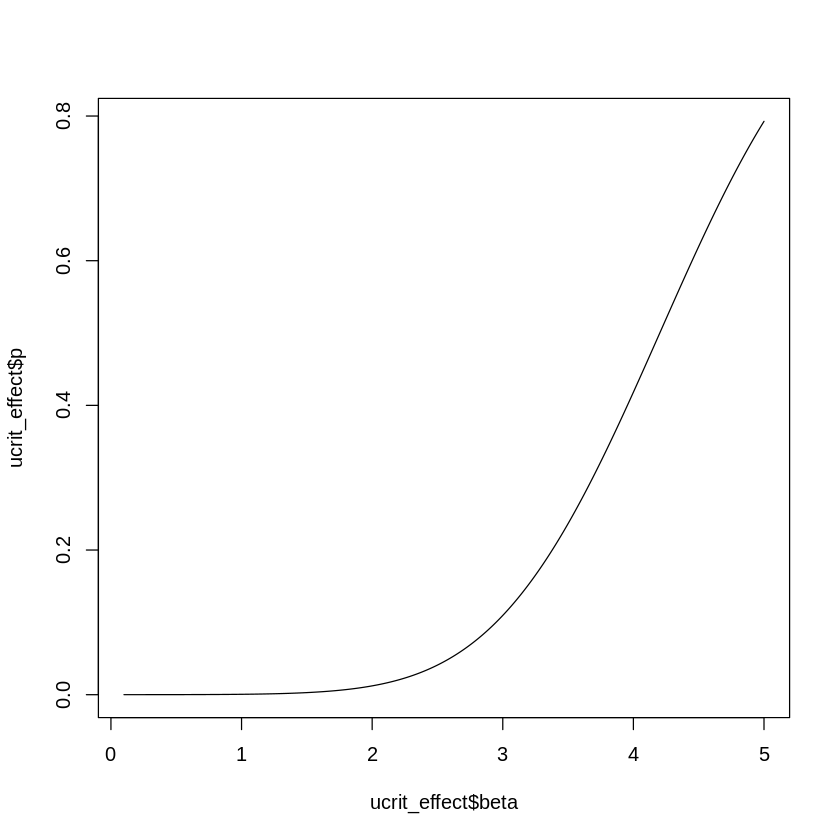

In [64]:
n = 159 #individuals
p = 132100 #SNPs for both null and alternative
f = 0.05 #MAF
#b.alt = 0.2 #effect size under the alternative hypothesis
x = rbinom(n, 2, f) #genotypes at 1 SNP for n ind 
y = sorted_meta$ucrit #phenotype distribution
se = summary( lm( y ~ x ) )$coeff[2,2] #pick se, and assume it stays constant and independent of beta
ucrit_effect <- data.table(beta=seq(0.1,5,0.01))
q.thresh = qchisq(1.74241e-05, df = 1, ncp = 0, lower = FALSE) #repeating thresholds in chi-square units
ucrit_effect[,p:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by="beta"]
plot(ucrit_effect$beta, ucrit_effect$p,type = "l")


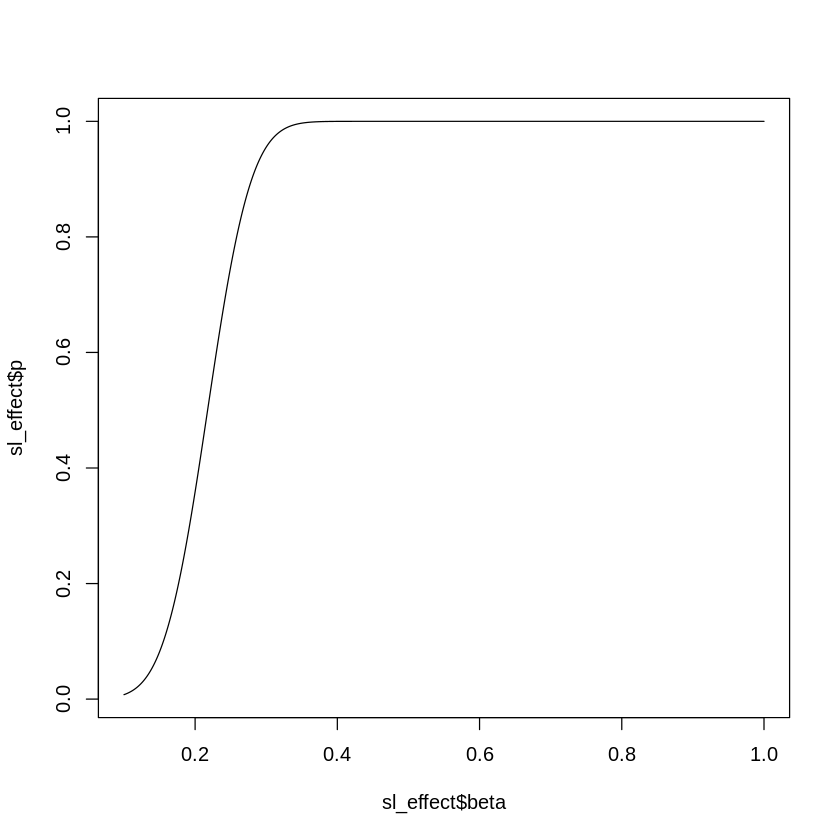

In [65]:
n = 159 #individuals
p = 132100 #SNPs 
f = 0.05 #MAF
#b.alt = 0.2 #effect size under the alternative hypothesis
x = rbinom(n, 2, f) #genotypes at 1 SNP for n ind 
y = sorted_meta$sl #phenotype distribution
se = summary( lm( y ~ x ) )$coeff[2,2] #pick se, and assume it stays constant and independent of beta
q.thresh = qchisq(7.336669e-06, df = 1, ncp = 0, lower = FALSE) #repeating thresholds in chi-square units
sl_effect <- data.table(beta=seq(0.1,1,0.001))
sl_effect[,p:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by="beta"]
plot(sl_effect$beta, sl_effect$p,type = "l")

In [ ]:
7.336669e-06

__"Reading the example more carefully, 3.2.2 is closer to what you want because it shows power vs. n. Except you know n and would instead want beta (effect size) and MAF on the x-axes. Even better would be beta and MAF as the x- and y-axes and power as the z-axis."__

In [66]:
head(ucrit_effect)

beta,p
0.10,1.921096e-05
0.11,1.959228e-05
0.12,2.001235e-05
0.13,2.047184e-05
0.14,2.097149e-05
0.15,2.151209e-05


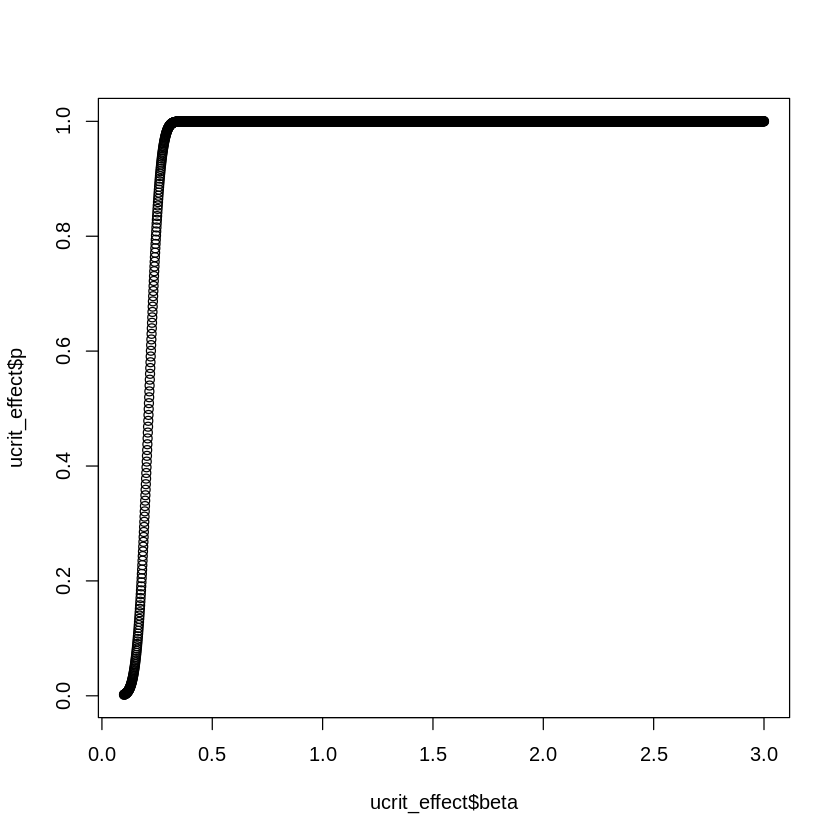

In [41]:
ucrit_effect <- data.table(beta=seq(0.1,3,0.001))

#for(i in 1:nrow(ucrit_effect)){
   # beta <- ucrit_effect[i, beta]
    ucrit_effect[,p:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1], by="beta"]
#}
plot(ucrit_effect$beta, ucrit_effect$p)

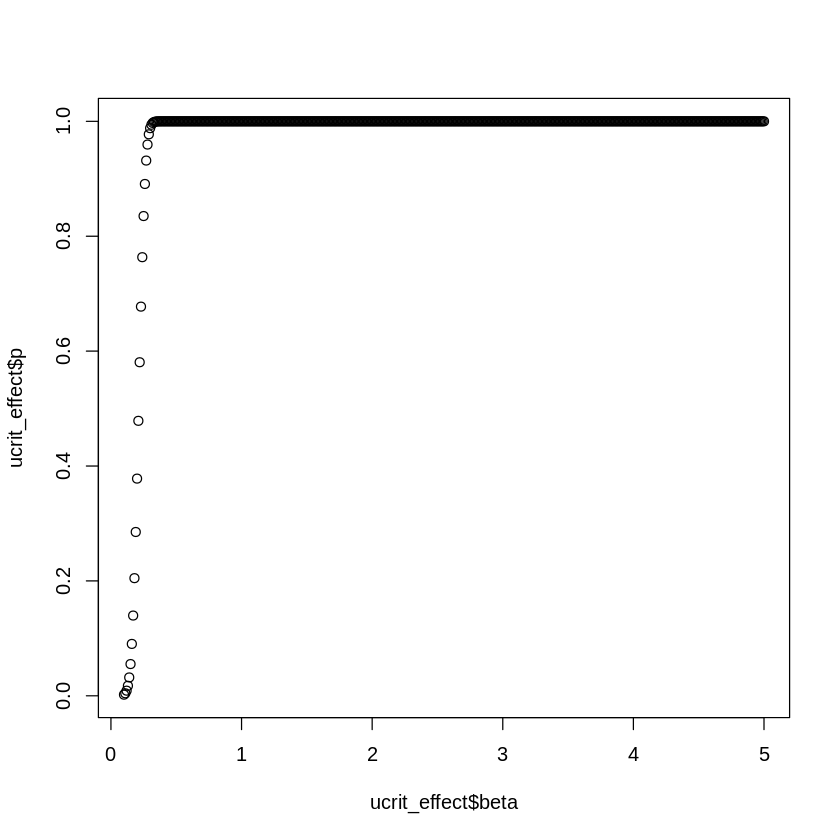

In [37]:

plot(ucrit_effect$beta, ucrit_effect$p)

In [30]:
pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)

[1] 1

In [ ]:
ucrit_effect[,p:=pchisq(q.thresh, df = 1, ncp = (beta/se)^2, lower = FALSE)[1]